In [1]:
import lake_model as lm
import pandas as pd

# OOP lake model

Still pretty rough...

## 1. Lake

The default is lake with an area of 0.2 km2, mean depth 5 m and residence time 0.7 years. Initial pH is 4.5, colour is 10 mgPt and the flow profile is `fjell`.

Alternatively, pass `kwargs` to the constructor to define a custom lake.

Volume:           1000000000 litres.
Mean annual flow: 119047619 litres/month.


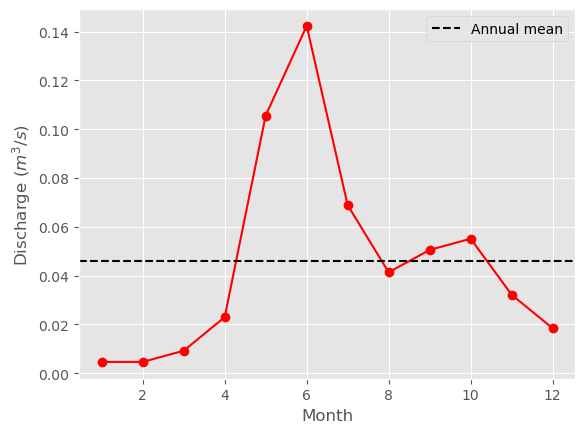

In [2]:
lake = lm.Lake(
    area=0.2,
    depth=5,
    tau=0.7,
    flow_prof="fjell",
    pH_lake0=4.5,
    toc_lake0=4,
)

print(f"Volume:           {lake.volume:.0f} litres.")
print(f"Mean annual flow: {lake.mean_annual_flow:.0f} litres/month.")

lake.plot_flow_profile()

## 2. Lime product

Either specify the name of an existing product (defined in `lime_products.xlsx`), or set `from_database=False` and pass the required arguments to the constructor to create a custom product.

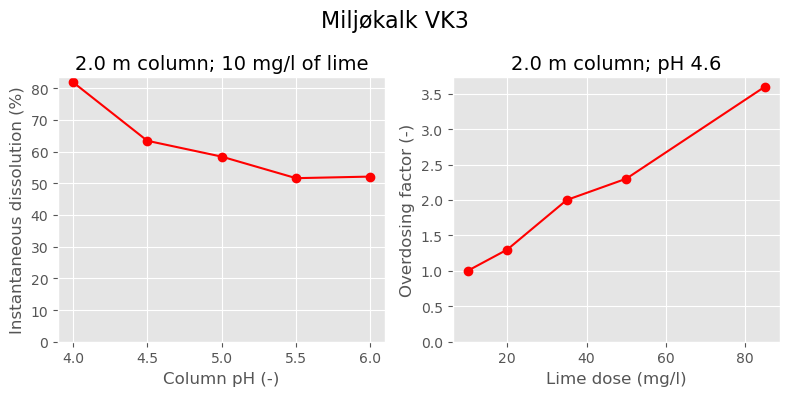

In [3]:
prod = lm.LimeProduct("Miljøkalk VK3")
prod.plot_column_data()

In [4]:
# # Custom product
# prod = lm.LimeProduct(
#     "test",
#     from_database=False,
#     ca_pct=40,
#     mg_pct=0,
#     dry_fac=0.7,
#     col_depth=5,
#     id_list=[70, 70, 70, 70, 70],
#     od_list=[1, 1, 1, 1, 1],
# )
# prod.plot_column_data()

## 3. Model

Requires as input a lake object and a lime product object. 

By default, the lime dose is 10 mg/l, the liming month is 1, the spreading method is `wet`, the soluble fraction for lake-bottom lime is 0.4, the bottom dissolution coefficient is 1 and the number of months simulated is 24. This behaviour can be changed/overridden by passing kwargs to the constructor.

Method factor for 'wet': 1.0.
Instananeous ΔCa-equivalents: 1.52 mg/l.
Slow, lake-bottom ΔCa-equivalents: 0.17 mg/l.


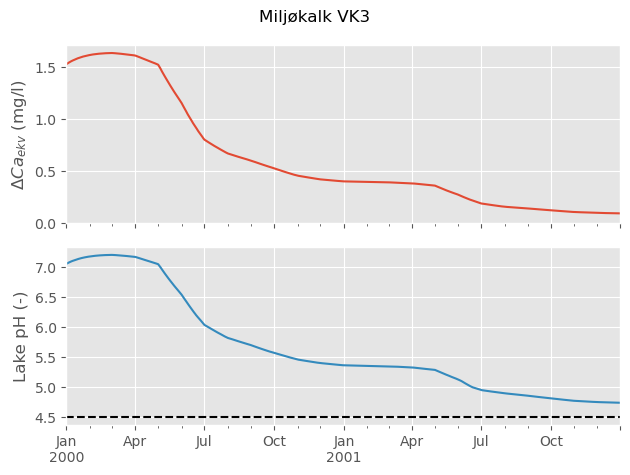

In [5]:
model = lm.Model(
    lake,
    prod,
    lime_dose=10,
    lime_month=1,
    spr_meth="wet",
    spr_prop=0.5,
    F_sol=0.4,
    K_L=1,
    n_months=24,
)

print(f"Method factor for '{model.spr_meth}': {model.method_fac:.1f}.")
print(f"Instananeous ΔCa-equivalents: {model.C_inst0:.2f} mg/l.")
print(f"Slow, lake-bottom ΔCa-equivalents: {model.C_bott0:.2f} mg/l.")

model.plot_result()

## 4. Modify and re-run

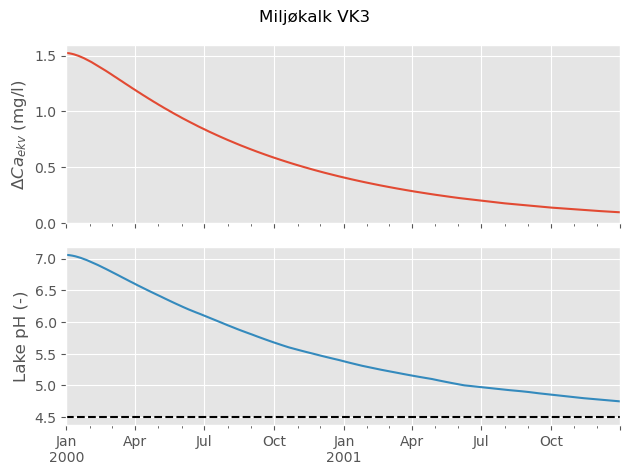

In [6]:
lake.flow_prof = "none"
model.plot_result()

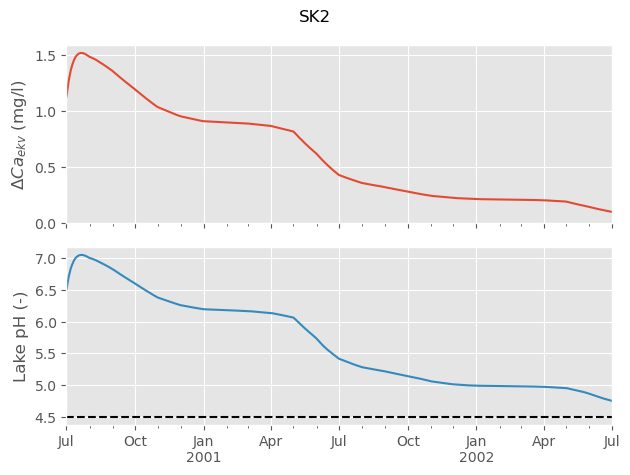

In [7]:
model.lime_month = 7
model.K_L = 3
model.F_sol = 1
model.lime_product = lm.LimeProduct("SK2")
lake.flow_prof = "fjell"
model.plot_result()